### Descripción del problema

Nota: Funcional. Descartamos las medidas de forest que solo tengan una direccion (up or down).  
Descartamos las medidas con errores de LAI alto.  
Descartamos las medidas con errores de clumping alto (up y down).  
Reservamos las medidas de 2023 para el test final.  
Eliminamos el outlier con id 20190918T154919_20190918T160136_T18SUJ.  
Seleccionamos las medidas insitu con una diferencia de dias menos de 5 dias con respecto a las adquisiciones del satelite.

### Variables y librerías

Definimos variables importantes:

In [232]:
file_name_sat = 'S2_SR_USA_2017_2024_SCL.csv'
file_name_insitu = 'NEON_LAI_USA_2017_2024.csv'

Importamos las librerías

In [233]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn import metrics

In [234]:
# Montamos nuestro Google Drive si usamos entorno de Colab
#from google.colab import drive
#drive.mount('/content/drive')

### 1. Datos de satelite

#### Cargamos el dataset de datos de satelite

Para entorno de **Google Colab**

In [235]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path = drive_path + file_name_sat

Para entorno **local**

In [236]:
# Definimos ruta de los archivos.
datadir_path = os.path.join('..','data')
dataset_path = os.path.join(datadir_path, file_name_sat)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [237]:
df_sat = pd.read_csv(dataset_path, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_sat.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_sat.drop(columns=['Unnamed: 0'], inplace=True) 
df_sat.head(5)

,id,longitude,latitude,time,B1,B2,B3,B4,B5,B6,...,B8,B8A,B9,B11,B12,SCL,QA10,QA20,QA60,Site_sat
0,20171222T182749_20171222T183128_T12TUK,-112.452455,40.177600,1513967574868,3597.0,3704.0,3788.0,3972.0,4316.0,4280.0,...,4272.0,4349.0,4724.0,1167.0,1091.0,11.0,NaN,NaN,0,Onaqui Ault
1,20171118T170559_20171118T170554_T15TYL,-89.586378,45.508922,1511025045890,8393.0,8072.0,7776.0,7568.0,7652.0,7527.0,...,7632.0,7314.0,10924.0,2087.0,2396.0,8.0,NaN,NaN,1024,Steigerwaldt Land Services
2,20171225T165709_20171225T165708_T15TYL,-89.586378,45.508922,1514221250709,3381.0,3469.0,3256.0,3317.0,3473.0,3863.0,...,4376.0,4062.0,3881.0,2315.0,1911.0,9.0,NaN,NaN,2048,Steigerwaldt Land Services
3,20171118T170559_20171118T170554_T15SUD,-95.192225,39.040513,1511025161923,7635.0,7848.0,7632.0,7480.0,7621.0,7438.0,...,7944.0,7295.0,10781.0,1901.0,2098.0,8.0,NaN,NaN,1024,University of Kansas Field Site
4,20171118T170559_20171118T170554_T15TYM,-89.537510,46.234042,1511025031342,5584.0,5352.0,5124.0,5016.0,5094.0,5038.0,...,4980.0,4760.0,6066.0,3001.0,2600.0,9.0,NaN,NaN,1024,Underc


In [238]:
df_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22975 entries, 0 to 22974
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         22975 non-null  object 
 1   longitude  22975 non-null  float64
 2   latitude   22975 non-null  float64
 3   time       22975 non-null  int64  
 4   B1         22949 non-null  float64
 5   B2         22959 non-null  float64
 6   B3         22960 non-null  float64
 7   B4         22960 non-null  float64
 8   B5         22960 non-null  float64
 9   B6         22960 non-null  float64
 10  B7         22960 non-null  float64
 11  B8         22960 non-null  float64
 12  B8A        22960 non-null  float64
 13  B9         22963 non-null  float64
 14  B11        22960 non-null  float64
 15  B12        22960 non-null  float64
 16  SCL        22960 non-null  float64
 17  QA10       16075 non-null  float64
 18  QA20       16075 non-null  float64
 19  QA60       22975 non-null  int64  
 20  Site_s

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'time' que está en formato Unix epoch time.

In [239]:
#df_sat['time'] = df_sat['time'].apply(lambda x: dt.datetime.utcfromtimestamp(x / 1000))
df_sat['time'] = pd.to_datetime(df_sat['time'], unit='ms')

**Ordenamos** el dataframe por Site y time, y **reseteamos** el indice.

In [240]:
df_sat.sort_values(by=['Site_sat','time'], inplace=True)
df_sat.reset_index(drop=True, inplace=True)

**Eliminamos columnas innecesarias.**  
QA10 y QA20 son columnas vacias.  
También descartamos las bandas de 60m que corresponden a aerosoles y vapor de agua: B1 y B9

In [241]:
df_sat.drop(columns=['B1', 'B9', 'QA10', 'QA20'], inplace=True)

**Eliminamos las filas** (espectros) correspondientes a **pixeles con nubes**  
Los pixes con nubes corresponden a: QA60 == 512 or QA60 == 1024 or QA60 == 2048  
Por lo tanto nos quedamos solo con los pixeles libres de nubes: QA60 == 0

In [242]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

22975

In [243]:
df_sat['QA60'].value_counts() # También vemos la cantidad de pixeles con nubes

QA60
0       15915
1024     5244
2048     1816
Name: count, dtype: int64

In [244]:
df_sat = df_sat[df_sat['QA60'] == 0] # Me quedo con las filas (pixeles) libre de nubes

In [245]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles con nubes

15915

**Elimino filas de no-vegetación**  
Me quedo con las filas (pixeles) de vegetación según la banda 'SCL' de Sentinel-2.  
Zonas de vegetación pueden estar cubiertas de nieve en alguna epoca del año.  
Por lo tanto, eliminamos esos pixeles.

In [246]:
len(df_sat) # Antes de eliminar filas vemos el tamaño del dataset

15915

In [247]:
df_sat = df_sat[df_sat['SCL'] == 4] # Me quedo con las filas (pixeles) de vegetación

In [248]:
len(df_sat) # Vemos como queda el tamaño del dataset luego de eliminar pixeles

5547

**Escalamos las bandas** a los valores de reflectancia reales (originalmente están multiplicados por 10000).

In [249]:
bandas = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12'] # Definimos una lista con las columnas correspondientes a las bandas

In [250]:
for banda in bandas: # Recorremos todas las bandas
    df_sat.loc[:,banda] = df_sat[banda].astype(float) # Forzamos el tipo de los datos para hacerlos float.
    df_sat.loc[:,banda] = df_sat[banda] * 0.0001 # Escalamos

In [251]:
# Vemos como queda nuestro dataset
df_sat.head()

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,SCL,QA60,Site_sat
23,20190128T154519_20190128T154758_T19TCJ,-71.287337,44.063892,2019-01-28 15:50:57.000,0.0543,0.0520,0.0584,0.0665,0.1536,0.1727,0.2460,0.2054,0.0793,0.0550,4.0,0,Bartlett Experimental Forest
24,20190128T154519_20190128T154758_T18TYP,-71.287337,44.063892,2019-01-28 15:51:01.000,0.0251,0.0346,0.0358,0.0649,0.1531,0.1739,0.2365,0.2108,0.0815,0.0570,4.0,0,Bartlett Experimental Forest
33,20190222T154241_20190222T154730_T19TCJ,-71.287337,44.063892,2019-02-22 15:50:52.000,0.0642,0.0854,0.0816,0.0890,0.1784,0.2129,0.2199,0.2268,0.1014,0.0616,4.0,0,Bartlett Experimental Forest
34,20190222T154241_20190222T154730_T18TYP,-71.287337,44.063892,2019-02-22 15:50:56.000,0.0438,0.0541,0.0619,0.0842,0.1787,0.2139,0.1845,0.2290,0.1034,0.0623,4.0,0,Bartlett Experimental Forest
63,20190508T153819_20190508T154933_T19TCJ,-71.287337,44.063892,2019-05-08 15:51:05.057,0.0388,0.0560,0.0564,0.0942,0.1683,0.1943,0.2432,0.2120,0.1615,0.0985,4.0,0,Bartlett Experimental Forest


#### Visualización y exploración

Visualizamos muestras de los espectros de vegetación en un gráfico

In [252]:
# Definimos la longitud de onda central de las bandas
central_wl = {
    'B2': 490,  # Banda 2 (Azul)
    'B3': 560,  # Banda 3 (Verde)
    'B4': 665,  # Banda 4 (Rojo)
    'B5': 705,  # Banda 5
    'B6': 740,  # Banda 6
    'B7': 783,  # Banda 7
    'B8': 842,  # Banda 8 (Infrarrojo cercano)
    'B8A': 865, # Banda 8A
    'B11': 1610, # Banda 11 (Infrarrojo de onda corta)
    'B12': 2190  # Banda 12
}

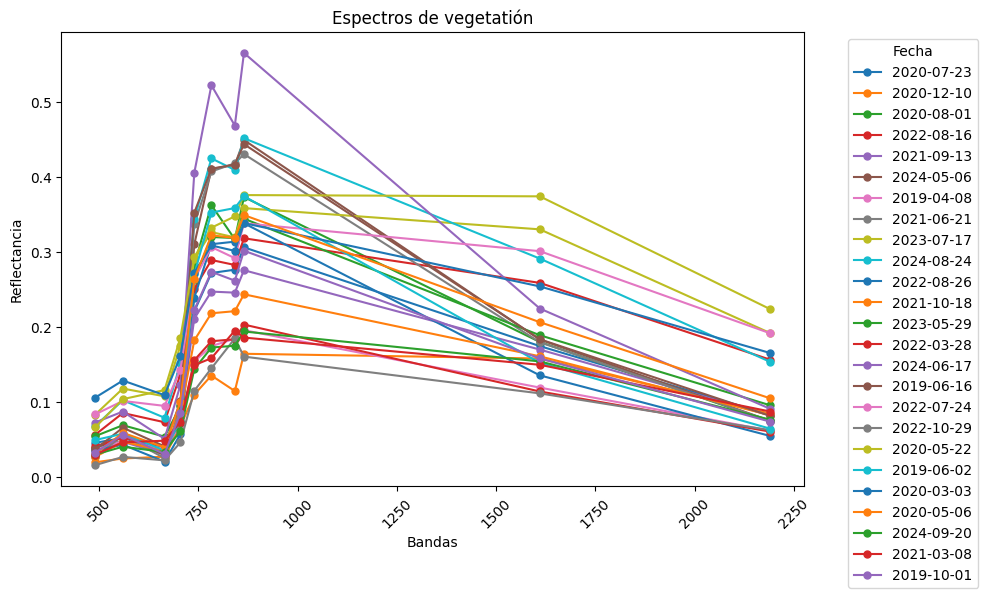

In [253]:
# Graficar diferentes espectros
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura

for index, row in df_sat.sample(25).iterrows():
    plt.plot([central_wl[band] for band in bandas], row[bandas], label=row['time'].strftime('%Y-%m-%d'), marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("Espectros de vegetatión")
plt.xlabel("Bandas")
plt.ylabel("Reflectancia")
plt.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show();

Calculamos el NDVI y graficamos series temporales de muestras de pixeles para verificar que se aproxima a la realidad

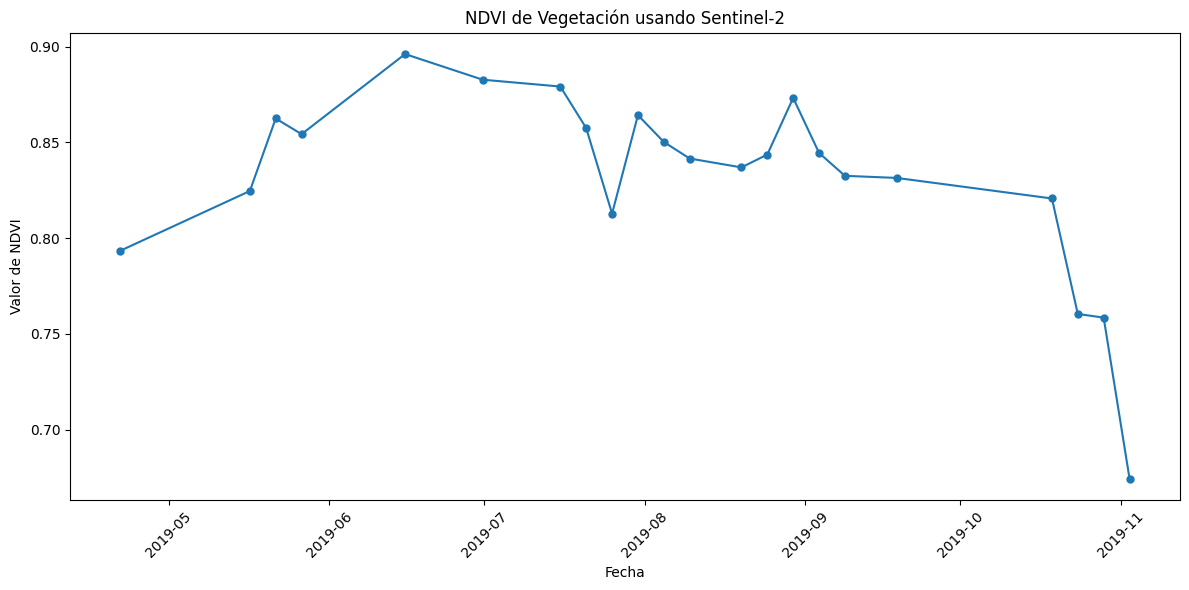

In [254]:
# Calcular NDVI para cada espectro (fila) del DataFrame
df_VI = df_sat.copy()
df_VI['NDVI'] = (df_VI['B8'] - df_VI['B4']) / (df_VI['B8'] + df_VI['B4'])

# Graficar el NDVI para el site y el año seleccionado
plt.figure(figsize=(12, 6))
mask_Lajas_2019 = (df_VI['Site_sat'] == 'Smithsonian Environmental Research Center') & (df_VI['time'].dt.year == 2019)
plt.plot(df_VI.loc[mask_Lajas_2019,'time'], df_VI.loc[mask_Lajas_2019,'NDVI'], marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("NDVI de Vegetación usando Sentinel-2")
plt.xlabel("Fecha")
plt.ylabel("Valor de NDVI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Image of vegetation phenology

![Image of vegetation phenology](https://www.scielo.org.mx/img/revistas/tl/v36n4//2395-8030-tl-36-04-393-gf1.png)

### 2. Datos de campo

#### Cargamos el dataset de medidas insitu

Para entorno de **Google Colab**

In [255]:
#drive_path = '/content/drive/MyDrive/Colab Notebooks/'
#!ls /content/drive/MyDrive/Colab\ Notebooks/
#dataset_path_insitu = drive_path + file_name_insitu

Para entorno **local**

In [256]:
# Definimos ruta de los archivos.
#datadir_path = os.path.join('..','data')
dataset_path_insitu = os.path.join(datadir_path, file_name_insitu)

**Importamos el dataset** con Pandas y visualizamos las primeras instancias

In [257]:
df_insitu = pd.read_csv(dataset_path_insitu, sep=',')

# Eliminamos columna innecesaria de indices importado
if 'Unnamed: 0' in df_insitu.columns: # Comprobamos si 'Unnamed: 0' está en las columnas
    # Eliminar la columna 'Unnamed: 0'
    df_insitu.drop(columns=['Unnamed: 0'], inplace=True) 
df_sat.head(5)

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,SCL,QA60,Site_sat
23,20190128T154519_20190128T154758_T19TCJ,-71.287337,44.063892,2019-01-28 15:50:57.000,0.0543,0.0520,0.0584,0.0665,0.1536,0.1727,0.2460,0.2054,0.0793,0.0550,4.0,0,Bartlett Experimental Forest
24,20190128T154519_20190128T154758_T18TYP,-71.287337,44.063892,2019-01-28 15:51:01.000,0.0251,0.0346,0.0358,0.0649,0.1531,0.1739,0.2365,0.2108,0.0815,0.0570,4.0,0,Bartlett Experimental Forest
33,20190222T154241_20190222T154730_T19TCJ,-71.287337,44.063892,2019-02-22 15:50:52.000,0.0642,0.0854,0.0816,0.0890,0.1784,0.2129,0.2199,0.2268,0.1014,0.0616,4.0,0,Bartlett Experimental Forest
34,20190222T154241_20190222T154730_T18TYP,-71.287337,44.063892,2019-02-22 15:50:56.000,0.0438,0.0541,0.0619,0.0842,0.1787,0.2139,0.1845,0.2290,0.1034,0.0623,4.0,0,Bartlett Experimental Forest
63,20190508T153819_20190508T154933_T19TCJ,-71.287337,44.063892,2019-05-08 15:51:05.057,0.0388,0.0560,0.0564,0.0942,0.1683,0.1943,0.2432,0.2120,0.1615,0.0985,4.0,0,Bartlett Experimental Forest


In [258]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9406 entries, 0 to 9405
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GBOV_ID                   9406 non-null   object 
 1   Site                      9406 non-null   object 
 2   GROUND_DATA_PI            9176 non-null   object 
 3   GROUND_DATA_PIs_Email     9176 non-null   object 
 4   GBOV_Email                9406 non-null   object 
 5   Network                   9406 non-null   object 
 6   Elevation                 9406 non-null   int64  
 7   IGBP_class                9406 non-null   object 
 8   Lat_IS                    9406 non-null   float64
 9   Lon_IS                    9406 non-null   float64
 10  TIME_IS                   9406 non-null   object 
 11  Version                   9406 non-null   float64
 12  up_flag                   7713 non-null   float64
 13  down_flag                 7713 non-null   float64
 14  LAI_Mill

#### Limpiamos y procesamos el dataset

Convertimos a tipo **datetime** la columna 'TIME_IS'

In [259]:
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS'])

Pasamos todos los valores **nulos** a NaN

In [260]:
# Reemplazar todos los valores -999 por NaN
df_insitu.replace(-999.0, np.nan, inplace=True)
df_insitu.replace(999.0, np.nan, inplace=True)
df_insitu.replace(-999, np.nan, inplace=True)
df_insitu.replace(999, np.nan, inplace=True)
df_insitu.replace('-999.0', np.nan, inplace=True)
df_insitu.replace('999.0', np.nan, inplace=True)
df_insitu.replace('-999', np.nan, inplace=True)
df_insitu.replace('999', np.nan, inplace=True)

len(df_insitu)

9406

**Eliminamos filas** fijandonos en las columnas del quality flag

In [261]:
# Nos quedamos con valores de up_flag = 0, que son los de mejor calidad,
# los demás los marcamos como nulos
mask_invalid_up = df_insitu['up_flag'] != 0
df_insitu.loc[mask_invalid_up,['up_flag','LAI_Warren_up','LAI_Warren_up_err']] = np.nan

# Lo mismo para down_flag
mask_invalid_down = df_insitu['down_flag'] != 0
df_insitu.loc[mask_invalid_down,['down_flag','LAI_Warren_down','LAI_Warren_down_err']] = np.nan

# Eliminamos filas donde ambas flags son nulas
df_insitu.dropna(subset=['up_flag','down_flag'], how='all', inplace=True)
len(df_insitu)

7486

Definimos las **columnas numéricas**

In [262]:
col_numericas = [
 'LAI_Miller_up',
 'LAI_Warren_up',
 'LAIe_Miller_up',
 'LAIe_Warren_up',
 'LAI_Miller_down',
 'LAI_Warren_down',
 'LAIe_Miller_down',
 'LAIe_Warren_down',
 'LAI_Miller_up_err',
 'LAI_Warren_up_err',
 'LAIe_Miller_up_err',
 'LAIe_Warren_up_err',
 'clumping_Miller_up',
 'clumping_Warren_up',
 'LAI_Miller_down_err',
 'LAI_Warren_down_err',
 'LAIe_Miller_down_err',
 'LAIe_Warren_down_err',
 'clumping_Miller_down',
 'clumping_Warren_down',
 'clumping_Miller_up_err',
 'clumping_Warren_up_err',
 'clumping_Miller_down_err',
 'clumping_Warren_down_err']

Miramos si existen caracteres no numericos en las columnas que impidan convertirlas a float.

In [263]:
for col in col_numericas:
    # print('\n',col)
    for valor in df_insitu[col]:
        try:
            # Intentar convertir a float, si falla significa que el valor no es numérico
            valor = str(valor)
            float(valor)  # Intentar convertir a float
        except ValueError:
            # Si no se puede convertir, es un valor no numérico
            print(valor)


(7.2
(7.9
(8.0
(8.0
(8
(9
(7.2
(7.9
(8.0
(8.0
(8
(9
1.0)e-05
1.7)e-05
1.7)e-05
1.9)e-05
4)e-05
5)e-05
1.0)e-05
1.7)e-05
1.7)e-05
1.9)e-05
4)e-05
5)e-05


Removemos caracteres no numericos y forzamos el cambio del tipo de datos

In [264]:
for col in col_numericas:
    if df_insitu[col].dtypes != 'float':
        #print(col)
        # Limpiamos las columnas numericas de caracteres indeseados.
        df_insitu[col] = df_insitu[col].str.strip().str.replace('(', '').str.replace('(', '').str.replace(')', '')  # .str.replace("[^0-9.e]", '', regex=True)
        #df_insitu[col].astype(float, errors='ignore')
        df_insitu[col] =  pd.to_numeric(df_insitu[col],errors='coerce')


Calculamos el LAI effective y el error de LAI effective

In [265]:
class_forest = ['Mixed Forest', 'Evergreen Needleleaf', 'Deciduous Broadleaf Forest', 'Evergreen Broadleaf', 'Evergreen Needleleaf Forest','Deciduous Broadleaf']

In [266]:
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down'] 
print(df_insitu['LAI_Warren'].isna().sum())
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = np.nan
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull(), 'LAI_Warren'] = np.nan
print(df_insitu['LAI_Warren'].isna().sum())
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull(), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err'] + df_insitu['LAI_Warren_down_err'] 


df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err']

#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAI_Warren'] = df_insitu['LAI_Warren_up']

df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards
df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_down']
df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren_err'] = df_insitu['LAI_Warren_down_err']


#df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) , 'LAI_Warren'] = df_insitu['LAI_Warren_down']
#df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) , 'LAI_Warren_err'] = df_insitu['LAI_Warren_down_err']

3702
3702


In [267]:
'''df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down'] 
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = np.nan
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull(), 'LAI_Warren'] = np.nan
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull(), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err'] + df_insitu['LAI_Warren_down_err'] 


df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err']

#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAI_Warren'] = df_insitu['LAI_Warren_up']

df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) , 'LAI_Warren'] = df_insitu['LAI_Warren_down']
df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) , 'LAI_Warren_err'] = df_insitu['LAI_Warren_down_err']'''

"df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down'] \ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = np.nan\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].notnull(), 'LAI_Warren'] = np.nan\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].notnull() & df_insitu['LAI_Warren_down'].notnull(), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err'] + df_insitu['LAI_Warren_down_err'] \n\n\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos la

In [268]:
'''df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & ~df_insitu['LAI_Warren_up'].isnull() & ~df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down'] 
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & ~df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = np.nan
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].isnull() & ~df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = np.nan


#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards
#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAI_Warren'] = np.nan

df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) , 'LAI_Warren'] = np.nan'''

"df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & ~df_insitu['LAI_Warren_up'].isnull() & ~df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down'] \ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & ~df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = np.nan\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].isnull() & ~df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = np.nan\n\n\n#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards\n#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_up']\ndf_insitu.loc[(df_insitu[

In [269]:
'''df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & ~df_insitu['LAI_Warren_up'].isnull() & ~df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down'] 
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & ~df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].isnull() & ~df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_down']


#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards
#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAI_Warren'] = df_insitu['LAI_Warren_up']

df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) , 'LAI_Warren'] = df_insitu['LAI_Warren_down']'''

"df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & ~df_insitu['LAI_Warren_up'].isnull() & ~df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down'] \ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & ~df_insitu['LAI_Warren_up'].isnull() & df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_up']\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0) & df_insitu['LAI_Warren_up'].isnull() & ~df_insitu['LAI_Warren_down'].isnull(), 'LAI_Warren'] = df_insitu['LAI_Warren_down']\n\n\n#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = np.nan # Descartamos las medidas de forest cuando son solo upwards\n#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (~df_insitu['IGBP_class'].isin(class_forest)), 'LAI_Warren'] = df_insitu['

In [270]:
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (~df_insitu['IGBP_class'].isin(class_forest))][['IGBP_class','LAI_Warren_up','LAI_Warren_down']]

,IGBP_class,LAI_Warren_up,LAI_Warren_down
1271,Grasslands,NaN,NaN
1273,Grasslands,NaN,NaN
1275,Grasslands,NaN,NaN
1575,Grasslands,NaN,NaN
1578,Grasslands,NaN,NaN
...,...,...,...
4851,Croplands,2.486923,NaN
4854,Croplands,5.180196,NaN
4856,Croplands,5.179295,NaN
4858,Croplands,5.138558,NaN


In [271]:
'''df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down'] 
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err'] + df_insitu['LAI_Warren_down_err']

#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'] == 'Grasslands'), 'LAI_Warren'] = df_insitu['LAI_Warren_up']
#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'] != 'Grasslands'), 'LAI_Warren'] = np.nan # df_insitu['LAI_Warren_up']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAI_Warren'] = df_insitu['LAI_Warren_up']

df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err']

#df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) & (df_insitu['IGBP_class'] == 'Grasslands'), 'LAI_Warren'] = df_insitu['LAI_Warren_down']
#df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) & (df_insitu['IGBP_class'] != 'Grasslands'), 'LAI_Warren'] = np.nan #df_insitu['LAI_Warren_down']
df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0), 'LAI_Warren'] = df_insitu['LAI_Warren_down']

df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0), 'LAI_Warren_err'] = df_insitu['LAI_Warren_down_err']'''

"df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAI_Warren'] = df_insitu['LAI_Warren_up'] + df_insitu['LAI_Warren_down'] \ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err'] + df_insitu['LAI_Warren_down_err']\n\n#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'] == 'Grasslands'), 'LAI_Warren'] = df_insitu['LAI_Warren_up']\n#df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()) & (df_insitu['IGBP_class'] != 'Grasslands'), 'LAI_Warren'] = np.nan # df_insitu['LAI_Warren_up']\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAI_Warren'] = df_insitu['LAI_Warren_up']\n\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAI_Warren_err'] = df_insitu['LAI_Warren_up_err']\n\n#df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0) & 

In [272]:
'''df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAIe_Miller'] = df_insitu['LAIe_Miller_up'] + df_insitu['LAIe_Miller_down']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAIe_Miller_err'] = df_insitu['LAIe_Miller_up_err'] + df_insitu['LAIe_Miller_down_err']

df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAIe_Miller'] = df_insitu['LAIe_Miller_up']
df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAIe_Miller_err'] = df_insitu['LAIe_Miller_up_err']

df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0), 'LAIe_Miller'] = df_insitu['LAIe_Miller_down']
df_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0), 'LAIe_Miller_err'] = df_insitu['LAIe_Miller_down_err']'''

"df_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAIe_Miller'] = df_insitu['LAIe_Miller_up'] + df_insitu['LAIe_Miller_down']\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'] == 0), 'LAIe_Miller_err'] = df_insitu['LAIe_Miller_up_err'] + df_insitu['LAIe_Miller_down_err']\n\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAIe_Miller'] = df_insitu['LAIe_Miller_up']\ndf_insitu.loc[(df_insitu['up_flag'] == 0) & (df_insitu['down_flag'].isnull()), 'LAIe_Miller_err'] = df_insitu['LAIe_Miller_up_err']\n\ndf_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0), 'LAIe_Miller'] = df_insitu['LAIe_Miller_down']\ndf_insitu.loc[(df_insitu['up_flag'].isnull()) & (df_insitu['down_flag'] == 0), 'LAIe_Miller_err'] = df_insitu['LAIe_Miller_down_err']"

In [273]:
# Descartamos medidas con errores mas altos
df_insitu = df_insitu[df_insitu['LAI_Warren_err'] <= 0.45]
df_insitu.loc[df_insitu['clumping_Warren_up_err'] >= 0.1,'LAI_Warren'] = np.nan
df_insitu.loc[df_insitu['clumping_Warren_down_err'] >= 0.3, 'LAI_Warren'] = np.nan

In [274]:
# Eliminamos las filas donde el LAI es nulo
df_insitu.dropna(subset=['LAI_Warren'], inplace=True)
len(df_insitu)

5351

In [275]:
df_insitu.head()

,GBOV_ID,Site,GROUND_DATA_PI,GROUND_DATA_PIs_Email,GBOV_Email,Network,Elevation,IGBP_class,Lat_IS,Lon_IS,...,LAIe_Miller_down_err,LAIe_Warren_down_err,clumping_Miller_down,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,LAI_Warren,LAI_Warren_err
0,GBOV_RM7_1223,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.017,0.022,0.75,0.80,0.029,0.04,0.11,0.19,3.89,0.19
2,GBOV_RM7_1235,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.070,0.110,0.76,0.74,0.033,0.05,0.08,0.17,5.37,0.41
6,GBOV_RM7_1211,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.090,0.120,0.74,0.79,0.029,0.05,0.05,0.09,5.95,0.29
8,GBOV_RM7_1253,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.060,0.070,0.77,0.83,0.030,0.05,0.08,0.14,5.47,0.30
10,GBOV_RM7_1247,Harvard Forest,Courtney Meier,cmeier@battelleecology.org,support-copernicus-gbov@acri-st.fr,NEON,351,Mixed Forest,42.5378,-72.171501,...,0.070,0.110,0.71,0.72,0.029,0.06,0.10,0.22,4.79,0.44


In [276]:
df_insitu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5351 entries, 0 to 9398
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   GBOV_ID                   5351 non-null   object             
 1   Site                      5351 non-null   object             
 2   GROUND_DATA_PI            5288 non-null   object             
 3   GROUND_DATA_PIs_Email     5288 non-null   object             
 4   GBOV_Email                5351 non-null   object             
 5   Network                   5351 non-null   object             
 6   Elevation                 5351 non-null   int64              
 7   IGBP_class                5351 non-null   object             
 8   Lat_IS                    5351 non-null   float64            
 9   Lon_IS                    5351 non-null   float64            
 10  TIME_IS                   5351 non-null   datetime64[ns, UTC]
 11  Version               

### 3. Combinación de los datasets

In [277]:
# Convertimos la columna de la fecha a formato datetime.
df_insitu['TIME_IS'] = pd.to_datetime(df_insitu['TIME_IS']).dt.tz_localize(None)

In [278]:
df_insitu.TIME_IS

0      2018-08-13
2      2018-08-13
6      2018-08-13
8      2018-08-13
10     2018-08-13
          ...    
9390   2017-09-19
9392   2018-10-01
9394   2018-08-14
9396   2018-08-14
9398   2018-08-14
Name: TIME_IS, Length: 5351, dtype: datetime64[ns]

In [279]:
df_coord = df_insitu[['Site','Lat_IS', 'Lon_IS']].drop_duplicates()
coordenadas = tuple(zip(df_coord['Site'].values.tolist(), df_coord['Lat_IS'].values.tolist(), df_coord['Lon_IS'].values.tolist()))
coordenadas

(('Harvard Forest', 42.5377998352051, -72.171501159668),
 ('Jones Ecological Research Center', 31.1948394775391, -84.468777),
 ('Konza Prairie Biological Station', 39.110446, -96.612935),
 ('Jornada', 32.5907, -106.84261),
 ('Lajas Experimental Station', 18.02125, -67.0769),
 ('Lenoir Landing', 31.853861, -88.161181),
 ('Moab', 38.24836, -109.38831),
 ('Niwot Ridge Mountain Research Station', 40.0543, -105.58245),
 ('Onaqui Ault', 40.1775894165039, -112.452438354492),
 ('Oak Ridge', 35.9641189575195, -84.282600402832),
 ('Ordway Swisher Biological Station', 29.6839, -81.9934),
 ('Pu u Maka ala Natural Area Reserve', 19.55309, -155.31731),
 ('Smithsonian Conservation Biology Institute',
  38.8929214477539,
  -78.1395034790039),
 ('Smithsonian Environmental Research Center', 38.89016, -76.5601),
 ('Soaproot Saddle', 37.03337, -119.26219),
 ('Santa Rita', 31.91068, -110.83549),
 ('Steigerwaldt Land Services', 45.5089416503906, -89.5863723754883),
 ('North Sterling', 40.461952, -103.02934)

Para cada site identificamos las medidas in_situ mas cercanas a la fecha de adquisicion del satélite

In [280]:
df_list = []

# Itera sobre cada coordenada
for site, lat, lon in coordenadas:
    # Filtra el DataFrame de df_insitu y df según el 'Site'
    df_insitu_site = df_insitu[df_insitu['Site'] == site]
    df_sat_site = df_sat[df_sat['Site_sat'] == site]

    rows = []

    # Itera sobre los datos de satélite y datos in situ
    for index_sat, date_sat in df_sat_site['time'].items():
        for index_insitu, date_insitu in df_insitu_site['TIME_IS'].items():
            # Calcula la diferencia en días entre las fechas
            dif = (date_insitu - date_sat) / np.timedelta64(1, 'D')

            if abs(dif) <= 5: # Diferencia maxima (en días) entre la medida de satelite y la  medida in situ
                # Crea una lista con la fila combinada de ambas fuentes
                row = list(df_sat_site.loc[index_sat]) + list(df_insitu_site.loc[index_insitu])
                rows.append(row)

    # Si se encontraron filas, procesa los datos
    if rows:
        # Crear el DataFrame con las filas acumuladas
        df_cross_site = pd.DataFrame(rows, columns=list(df_sat_site.columns) + list(df_insitu_site.columns))

        # Añadir una columna 'delta' con la diferencia en tiempo entre el satélite y las mediciones in situ
        df_cross_site['delta'] = abs(df_cross_site['time'] - df_cross_site['TIME_IS'])

        # Añadir las fechas separadas de 'date_sat' y 'date_insitu'
        df_cross_site['date_sat'] = df_cross_site['time'].dt.date
        df_cross_site['date_insitu'] = df_cross_site['TIME_IS'].dt.date

        # Ordenar y eliminar duplicados por 'date_insitu'
        df_cross_site = df_cross_site.sort_values(by=['date_insitu', 'delta']).drop_duplicates(subset='date_insitu', keep='first')

        # Ordenar y eliminar duplicados por 'date_sat'
        df_cross_site = df_cross_site.sort_values(by=['date_sat', 'delta']).drop_duplicates(subset='date_sat', keep='first')



        # Agregar el DataFrame de este sitio a la lista
        df_list.append(df_cross_site)

# Combinar todos los DataFrames en uno solo
df_cross = pd.concat(df_list, axis=0, ignore_index=True)

# Mostrar el DataFrame final
df_cross

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,...,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,LAI_Warren,LAI_Warren_err,delta,date_sat,date_insitu
0,20190607T153819_20190607T154303_T18TYN,-72.171458,42.537834,2019-06-07 15:51:23.000,0.0198,0.0532,0.0169,0.0982,0.3507,0.4087,...,0.860000,0.029,0.04,0.090000,0.150000,4.030000,0.170000,3 days 10:17:23,2019-06-07,2019-06-04
1,20190627T153819_20190627T154123_T18TYN,-72.171458,42.537834,2019-06-27 15:51:23.000,0.0236,0.0405,0.0193,0.0782,0.3244,0.4116,...,0.900000,0.027,0.04,0.100000,0.190000,4.820000,0.220000,4 days 13:44:37,2019-06-27,2019-07-02
2,20190712T153911_20190712T154425_T18TYN,-72.171458,42.537834,2019-07-12 15:51:20.431,0.0197,0.0203,0.0126,0.0247,0.0888,0.1154,...,0.910000,0.027,0.04,0.110000,0.180000,3.871000,0.195000,3 days 13:53:39.569000,2019-07-12,2019-07-16
3,20190801T153911_20190801T154113_T18TYN,-72.171458,42.537834,2019-08-01 15:51:19.875,0.0176,0.0422,0.0188,0.0757,0.3112,0.3827,...,0.780000,0.030,0.05,0.080000,0.150000,3.790000,0.210000,2 days 09:45:19.875000,2019-08-01,2019-07-30
4,20190826T153819_20190826T154455_T18TYN,-72.171458,42.537834,2019-08-26 15:51:19.743,0.0204,0.0405,0.0182,0.0711,0.2746,0.3450,...,0.960000,0.029,0.05,0.060000,0.090000,4.281000,0.219000,0 days 14:23:40.257000,2019-08-26,2019-08-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,20220518T155819_20220518T160526_T17RMM,-81.436323,28.125084,2022-05-18 16:15:28.715,0.0786,0.1012,0.1058,0.1637,0.2506,0.2834,...,0.944939,NaN,NaN,0.040894,0.058853,0.883596,0.039789,2 days 03:17:28.715000,2022-05-18,2022-05-16
777,20220617T155829_20220617T161036_T17RMM,-81.436323,28.125084,2022-06-17 16:15:33.121,0.0785,0.1092,0.1030,0.1676,0.2745,0.3087,...,0.936141,NaN,NaN,0.034686,0.064837,1.094505,0.053315,4 days 03:58:33.121000,2022-06-17,2022-06-13
778,20220702T155831_20220702T160658_T17RMM,-81.436323,28.125084,2022-07-02 16:15:42.120,0.0766,0.1068,0.0961,0.1680,0.2857,0.3193,...,0.916421,NaN,NaN,0.035652,0.070347,1.171977,0.069838,4 days 01:28:42.120000,2022-07-02,2022-06-28
779,20220712T155921_20220712T161132_T17RMM,-81.436323,28.125084,2022-07-12 16:15:41.829,0.0635,0.1009,0.0870,0.1681,0.2862,0.3219,...,0.896217,NaN,NaN,0.045395,0.080408,1.372982,0.086343,0 days 18:33:18.171000,2022-07-12,2022-07-13


In [281]:
#df_cross.sort_index()[['Site','id','date_sat','date_insitu','time','TIME_IS','delta']]

In [282]:
#df_cross = df_cross.sort_values(by = ['Site','time']).reset_index(drop=True)

In [283]:
df_cross[['Site','id','date_sat','date_insitu','time','TIME_IS','delta']]

,Site,id,date_sat,date_insitu,time,TIME_IS,delta
0,Harvard Forest,20190607T153819_20190607T154303_T18TYN,2019-06-07,2019-06-04,2019-06-07 15:51:23.000,2019-06-04 05:34:00,3 days 10:17:23
1,Harvard Forest,20190627T153819_20190627T154123_T18TYN,2019-06-27,2019-07-02,2019-06-27 15:51:23.000,2019-07-02 05:36:00,4 days 13:44:37
2,Harvard Forest,20190712T153911_20190712T154425_T18TYN,2019-07-12,2019-07-16,2019-07-12 15:51:20.431,2019-07-16 05:45:00,3 days 13:53:39.569000
3,Harvard Forest,20190801T153911_20190801T154113_T18TYN,2019-08-01,2019-07-30,2019-08-01 15:51:19.875,2019-07-30 06:06:00,2 days 09:45:19.875000
4,Harvard Forest,20190826T153819_20190826T154455_T18TYN,2019-08-26,2019-08-27,2019-08-26 15:51:19.743,2019-08-27 06:15:00,0 days 14:23:40.257000
...,...,...,...,...,...,...,...
776,Disney Wilderness Preserve,20220518T155819_20220518T160526_T17RMM,2022-05-18,2022-05-16,2022-05-18 16:15:28.715,2022-05-16 12:58:00,2 days 03:17:28.715000
777,Disney Wilderness Preserve,20220617T155829_20220617T161036_T17RMM,2022-06-17,2022-06-13,2022-06-17 16:15:33.121,2022-06-13 12:17:00,4 days 03:58:33.121000
778,Disney Wilderness Preserve,20220702T155831_20220702T160658_T17RMM,2022-07-02,2022-06-28,2022-07-02 16:15:42.120,2022-06-28 14:47:00,4 days 01:28:42.120000
779,Disney Wilderness Preserve,20220712T155921_20220712T161132_T17RMM,2022-07-12,2022-07-13,2022-07-12 16:15:41.829,2022-07-13 10:49:00,0 days 18:33:18.171000


Seleccion de features

In [284]:
features_sel = ['Site',
 'Lat_IS',
 'Lon_IS',
 'date_sat',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'NDVI',
 'Network',
 'Elevation',
 'IGBP_class',
 'date_insitu',
 'delta',
 'LAIe_Miller',
 'LAIe_Miller_err']

In [285]:
#df_cross = df_cross[features_sel]

In [286]:
df_cross

,id,longitude,latitude,time,B2,B3,B4,B5,B6,B7,...,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,LAI_Warren,LAI_Warren_err,delta,date_sat,date_insitu
0,20190607T153819_20190607T154303_T18TYN,-72.171458,42.537834,2019-06-07 15:51:23.000,0.0198,0.0532,0.0169,0.0982,0.3507,0.4087,...,0.860000,0.029,0.04,0.090000,0.150000,4.030000,0.170000,3 days 10:17:23,2019-06-07,2019-06-04
1,20190627T153819_20190627T154123_T18TYN,-72.171458,42.537834,2019-06-27 15:51:23.000,0.0236,0.0405,0.0193,0.0782,0.3244,0.4116,...,0.900000,0.027,0.04,0.100000,0.190000,4.820000,0.220000,4 days 13:44:37,2019-06-27,2019-07-02
2,20190712T153911_20190712T154425_T18TYN,-72.171458,42.537834,2019-07-12 15:51:20.431,0.0197,0.0203,0.0126,0.0247,0.0888,0.1154,...,0.910000,0.027,0.04,0.110000,0.180000,3.871000,0.195000,3 days 13:53:39.569000,2019-07-12,2019-07-16
3,20190801T153911_20190801T154113_T18TYN,-72.171458,42.537834,2019-08-01 15:51:19.875,0.0176,0.0422,0.0188,0.0757,0.3112,0.3827,...,0.780000,0.030,0.05,0.080000,0.150000,3.790000,0.210000,2 days 09:45:19.875000,2019-08-01,2019-07-30
4,20190826T153819_20190826T154455_T18TYN,-72.171458,42.537834,2019-08-26 15:51:19.743,0.0204,0.0405,0.0182,0.0711,0.2746,0.3450,...,0.960000,0.029,0.05,0.060000,0.090000,4.281000,0.219000,0 days 14:23:40.257000,2019-08-26,2019-08-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,20220518T155819_20220518T160526_T17RMM,-81.436323,28.125084,2022-05-18 16:15:28.715,0.0786,0.1012,0.1058,0.1637,0.2506,0.2834,...,0.944939,NaN,NaN,0.040894,0.058853,0.883596,0.039789,2 days 03:17:28.715000,2022-05-18,2022-05-16
777,20220617T155829_20220617T161036_T17RMM,-81.436323,28.125084,2022-06-17 16:15:33.121,0.0785,0.1092,0.1030,0.1676,0.2745,0.3087,...,0.936141,NaN,NaN,0.034686,0.064837,1.094505,0.053315,4 days 03:58:33.121000,2022-06-17,2022-06-13
778,20220702T155831_20220702T160658_T17RMM,-81.436323,28.125084,2022-07-02 16:15:42.120,0.0766,0.1068,0.0961,0.1680,0.2857,0.3193,...,0.916421,NaN,NaN,0.035652,0.070347,1.171977,0.069838,4 days 01:28:42.120000,2022-07-02,2022-06-28
779,20220712T155921_20220712T161132_T17RMM,-81.436323,28.125084,2022-07-12 16:15:41.829,0.0635,0.1009,0.0870,0.1681,0.2862,0.3219,...,0.896217,NaN,NaN,0.045395,0.080408,1.372982,0.086343,0 days 18:33:18.171000,2022-07-12,2022-07-13


In [287]:
df_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   id                        781 non-null    object         
 1   longitude                 781 non-null    float64        
 2   latitude                  781 non-null    float64        
 3   time                      781 non-null    datetime64[ns] 
 4   B2                        781 non-null    float64        
 5   B3                        781 non-null    float64        
 6   B4                        781 non-null    float64        
 7   B5                        781 non-null    float64        
 8   B6                        781 non-null    float64        
 9   B7                        781 non-null    float64        
 10  B8                        781 non-null    float64        
 11  B8A                       781 non-null    float64        
 12  B11     

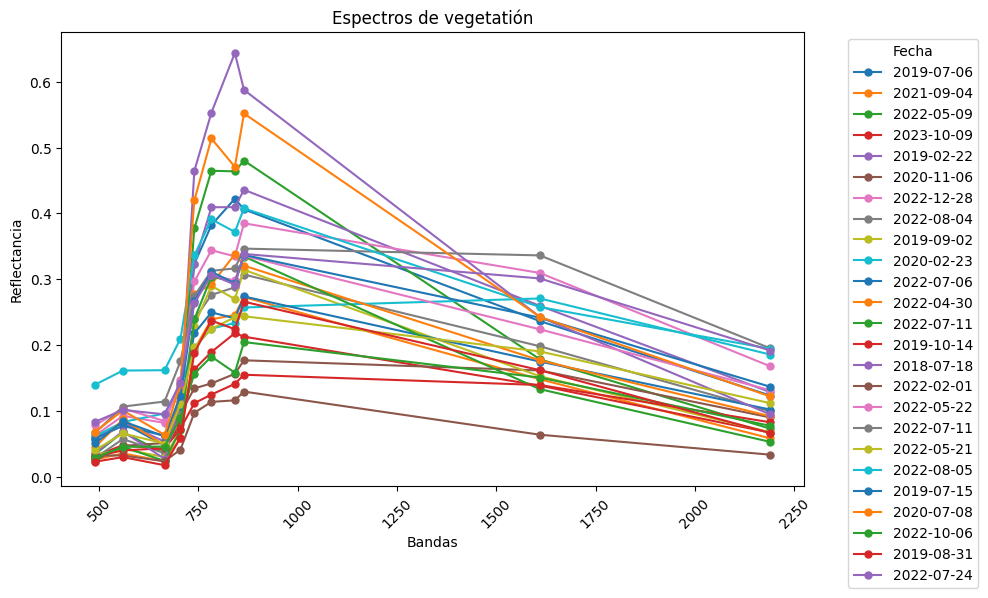

In [288]:
import matplotlib.pyplot as plt

# Graficar diferentes espectros
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura

for index, row in df_cross.sample(25).iterrows():
    plt.plot([central_wl[band] for band in bandas], row[bandas], label=row['date_sat'].strftime('%Y-%m-%d'), marker='o', linestyle='-', markersize=5)

# Configuración del gráfico
plt.title("Espectros de vegetatión")
plt.xlabel("Bandas")
plt.ylabel("Reflectancia")
plt.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show()

C:\Users\josea\AppData\Local\Temp\ipykernel_24032\1880779134.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # Elegir un mapa de colores (puedes cambiar 'viridis' por otro mapa como 'plasma', 'inferno', etc.)


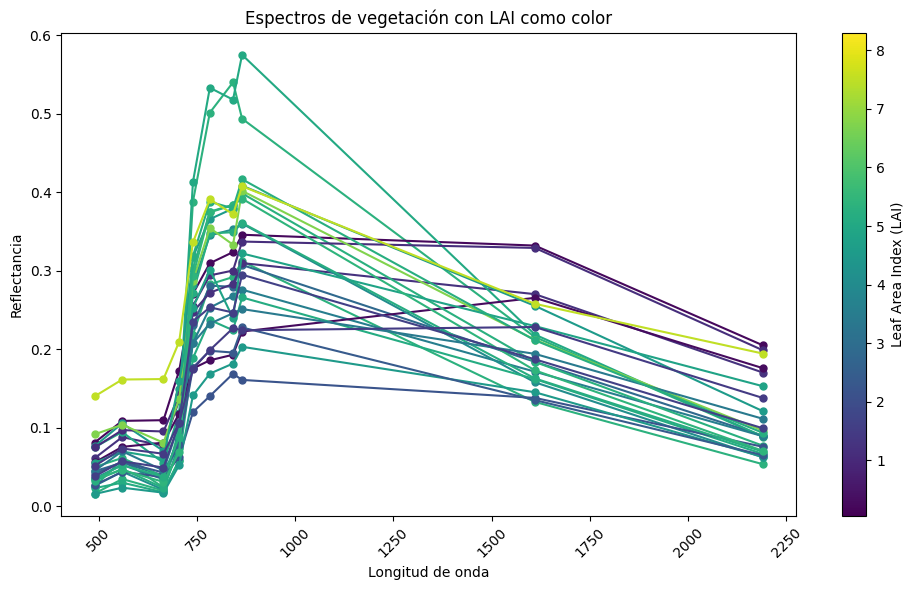

In [289]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Graficar diferentes espectros
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and an axes object

# Crear una lista de colores basada en el valor de LAI
cmap = cm.get_cmap('viridis')  # Elegir un mapa de colores (puedes cambiar 'viridis' por otro mapa como 'plasma', 'inferno', etc.)
norm = plt.Normalize(df_cross['LAI_Warren'].min(), df_cross['LAI_Warren'].max())  # Normalizar el rango del LAI

for index, row in df_cross.sample(25).iterrows():
    # Obtener el valor del LAI para esta fila
    lai_value = row['LAI_Warren']

    # Mapear el valor de LAI a un color
    color = cmap(norm(lai_value))  # Obtener el color correspondiente al LAI

    # Graficar el espectro, usando el valor del LAI como color de la línea
    ax.plot([central_wl[band] for band in bandas], row[bandas], label=row['date_sat'].strftime('%Y-%m-%d'),
             marker='o', linestyle='-', markersize=5, color=color)

# Añadir barra de colores para mostrar la escala del LAI
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para la barra de colores
fig.colorbar(sm, ax=ax, label='Leaf Area Index (LAI)') # Associate colorbar with the axes

# Configuración del gráfico
ax.set_title("Espectros de vegetación con LAI como color") # Use ax.set_title instead of plt.title
ax.set_xlabel("Longitud de onda") # Use ax.set_xlabel instead of plt.xlabel
ax.set_ylabel("Reflectancia") # Use ax.set_ylabel instead of plt.ylabel
#ax.legend(title="Fecha", bbox_to_anchor=(1.05, 1), loc='upper left')  # Mueve la leyenda fuera de la gráfica

# Mostrar gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas de las bandas
plt.tight_layout()  # Ajustar el espacio
plt.show()

In [290]:
df_cross.describe()

,longitude,latitude,time,B2,B3,B4,B5,B6,B7,B8,...,LAIe_Warren_down_err,clumping_Miller_down,clumping_Warren_down,clumping_Miller_up_err,clumping_Warren_up_err,clumping_Miller_down_err,clumping_Warren_down_err,LAI_Warren,LAI_Warren_err,delta
count,781.000000,781.000000,781,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,...,772.000000,772.000000,772.000000,628.000000,628.000000,772.000000,772.000000,781.000000,781.000000,781
mean,-89.384394,34.361636,2021-02-03 08:03:11.069989888,0.041035,0.061564,0.046966,0.097767,0.242784,0.291699,0.294238,...,0.050985,0.863163,0.873996,0.031294,0.051841,0.078406,0.139430,3.497351,0.202371,2 days 01:38:31.838450704
min,-155.317365,18.021193,2018-03-14 16:44:19.527000,0.006900,0.016300,0.004000,0.020600,0.072500,0.086400,0.091000,...,0.001157,0.460000,0.480000,0.014651,0.027582,0.021669,0.040000,0.045000,0.006000,0 days 00:03:31.465000
25%,-95.192225,31.194807,2019-08-31 21:00:04.055000064,0.026700,0.045000,0.027100,0.073700,0.189200,0.220200,0.227400,...,0.022182,0.800000,0.816467,0.025061,0.040995,0.051041,0.090623,1.580000,0.116965,0 days 20:28:29.750000
50%,-84.468856,35.964142,2021-05-08 16:15:13.609999872,0.036400,0.057700,0.038500,0.090500,0.244400,0.289000,0.287800,...,0.040000,0.879623,0.890001,0.029724,0.050000,0.070000,0.130000,4.027000,0.201176,1 days 18:50:29
75%,-78.071593,39.110402,2022-05-19 16:34:52.887000064,0.051400,0.074900,0.060400,0.118000,0.289600,0.356200,0.352400,...,0.070000,0.936940,0.945096,0.035000,0.059115,0.097984,0.176339,5.050000,0.289468,3 days 02:41:33.777000
max,-67.076933,47.128225,2023-12-09 16:15:10.948000,0.140000,0.161400,0.162000,0.209700,0.506300,0.562000,0.643700,...,0.260921,0.991323,0.995928,0.109328,0.096194,0.266299,0.296353,8.300687,0.450000,4 days 23:49:49.977000
std,20.957481,8.730732,NaN,0.020303,0.023313,0.026399,0.032705,0.075477,0.095788,0.096012,...,0.039122,0.086454,0.085889,0.010167,0.013414,0.033307,0.058003,1.937732,0.108163,1 days 09:19:17.203345675


Exportamos el dataframe a un archivo csv

In [291]:
#df_cross.to_csv(drive_path + 'Sentinel2_SR_NEON_USA_LAI_2017_2024.csv')

### 4. Mini EDA

Dividimos en train y test

In [292]:
#df_cross = df_cross[~(df_cross['IGBP_class'] == 'Open Shrublands')]

In [293]:
df_cross = df_cross[pd.to_datetime(df_cross['date_insitu']) < pd.to_datetime('2023-01-01')]

In [294]:
df_cross['TIME_IS'].dt.year.value_counts()

TIME_IS
2019    220
2021    185
2022    163
2020     92
2018     45
Name: count, dtype: int64

In [295]:
df_cross['IGBP_class'].value_counts()

IGBP_class
Mixed Forest                   146
Deciduous Broadleaf Forest     122
Grasslands                     110
Evergreen Needleleaf           103
Deciduous Broadleaf             85
Evergreen Broadleaf             58
Croplands                       49
Open Shrublands                 29
Evergreen Needleleaf Forest      3
Name: count, dtype: int64

IGBP_class  
Mixed Forest                   230  
Evergreen Needleleaf           158  
Deciduous Broadleaf            138  
Deciduous Broadleaf Forest     134  
Grasslands                     117  
Evergreen Broadleaf             72  
Croplands                       67  
Open Shrublands                 33  
Evergreen Needleleaf Forest     30  
Name: count, dtype: int64

In [296]:
#df_cross = df_cross[~(df_cross.IGBP_class == 'Open Shrublands')]

In [297]:
df_cross = df_cross[~(df_cross['id'] == '20190918T154919_20190918T160136_T18SUJ')]

In [298]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_cross, test_size=0.2, stratify=df_cross['IGBP_class'] ,random_state=42)
print(len(train_set))
print(len(test_set))

563
141


Definimos el target y las features

In [299]:
target = 'LAI_Warren'

In [300]:
features = bandas
features

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

Definimos X_train, y_train

In [301]:
X_train = train_set[features]
y_train = train_set[target]

X_test = test_set[features]
y_test = test_set[target]

Vemos la distribución de la variable objetivo

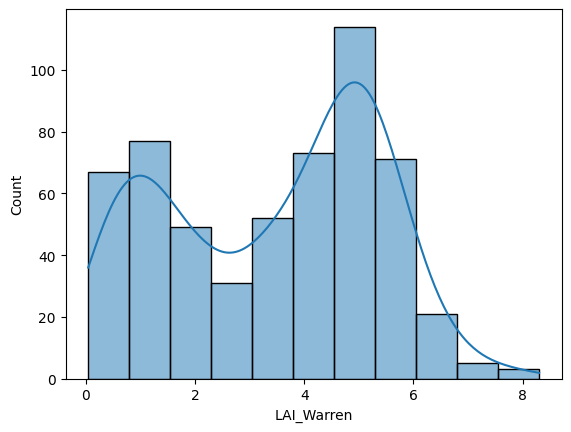

In [302]:
sns.histplot(x= target, data = train_set, kde = True);

Vemos las features (bandas) mas correlacionadas con el target

In [303]:
corr = train_set[features + [target]].corr()
np.abs(corr[target].sort_values(ascending = False))

LAI_Warren    1.000000
B7            0.273648
B8            0.266038
B8A           0.253629
B6            0.201169
B2            0.346814
B3            0.405247
B5            0.516884
B4            0.598850
B11           0.603558
B12           0.700520
Name: LAI_Warren, dtype: float64

<Axes: >

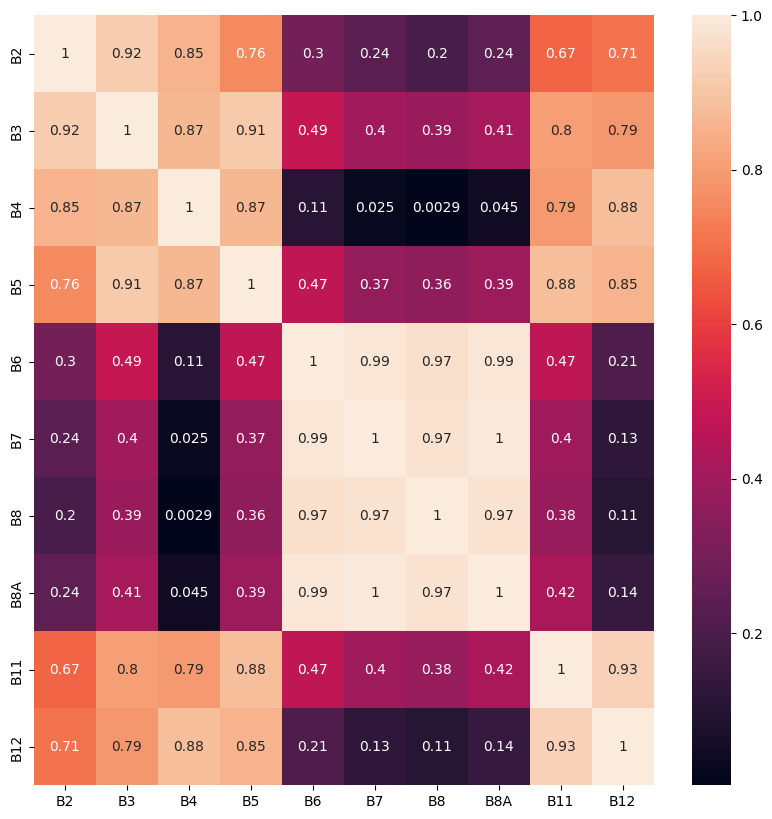

In [304]:
corr = train_set[features].corr()

plt.figure(figsize=(10,10))
sns.heatmap(abs(corr), annot=True)

<Axes: >

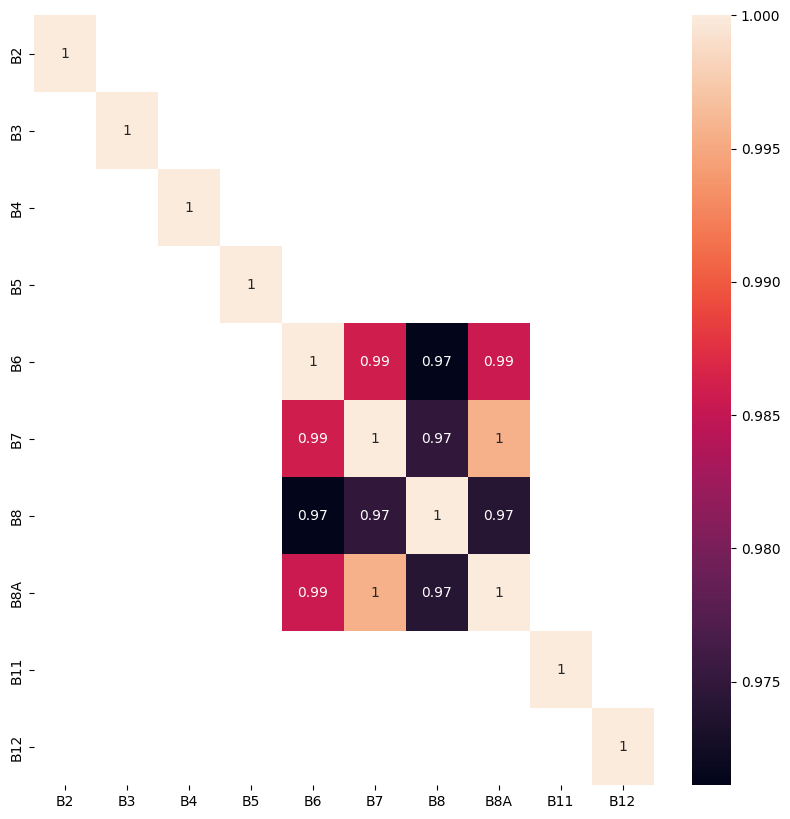

In [305]:
high_corr = corr[abs(corr) > 0.95]
plt.figure(figsize=(10,10))
sns.heatmap(abs(high_corr), annot=True)

La más alta correlación entre bandas es:  
B7-B8A del 100%.  
B6-B7 del 99%.  
B6-B8A del 99%.  
B7-B8 del 98%.  
B6-B8 del 97%.  
B8-B8A del 97%.


Descarto B8A y B6 que tienen una correlacion casi total con B7 que es la variable mas determinante en el target.

In [306]:
bandas_eliminar = ['B6','B8A']
bandas_sel = [banda for banda in bandas if banda not in bandas_eliminar]
bandas_sel

['B2', 'B3', 'B4', 'B5', 'B7', 'B8', 'B11', 'B12']

In [307]:
#features = bandas_sel
#bandas = bandas_sel

Feature selecction

In [308]:
from sklearn.ensemble import RandomForestRegressor

X = X_train[features]
Y = y_train

rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X, Y)

names = X.columns
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.5942,B12
1,0.0691,B11
2,0.0657,B7
3,0.0611,B8A
4,0.0460,B2
5,0.0390,B5
6,0.0360,B3
7,0.0321,B4
8,0.0305,B6
9,0.0263,B8


Vemos los outliers

In [309]:
'''import seaborn as sns

# Graficar boxplot para detectar outliers en las bandas seleccionadas
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[bandas])
plt.title("Detección de outliers en las bandas de Sentinel-2")
plt.xticks(rotation=45)
plt.show()'''

'import seaborn as sns\n\n# Graficar boxplot para detectar outliers en las bandas seleccionadas\nplt.figure(figsize=(12, 6))\nsns.boxplot(data=df[bandas])\nplt.title("Detección de outliers en las bandas de Sentinel-2")\nplt.xticks(rotation=45)\nplt.show()'

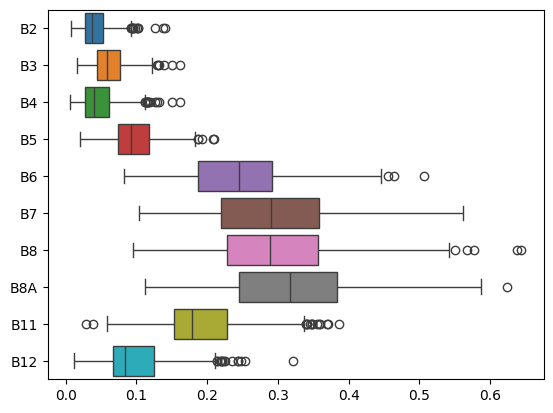

In [310]:
sns.boxplot(data = train_set[bandas], orient = "h");

### Preparacion de features

In [311]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[bandas]), columns=bandas)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[bandas]), columns=bandas)

### Construccion de modelo base

#### Linear regression

In [312]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled,y_train)


LinearRegression()

Para train

In [313]:
y_pred = lin_reg.predict(X_train_scaled)

In [314]:
argumentos = (y_train, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_train_scaled, y_train))

MSE: 1.092617927757032
RMSE: 1.0452836589926353
MAE: 0.8294852228230529
MAPE: 0.7060176330984035
R2: 0.7139458955113072


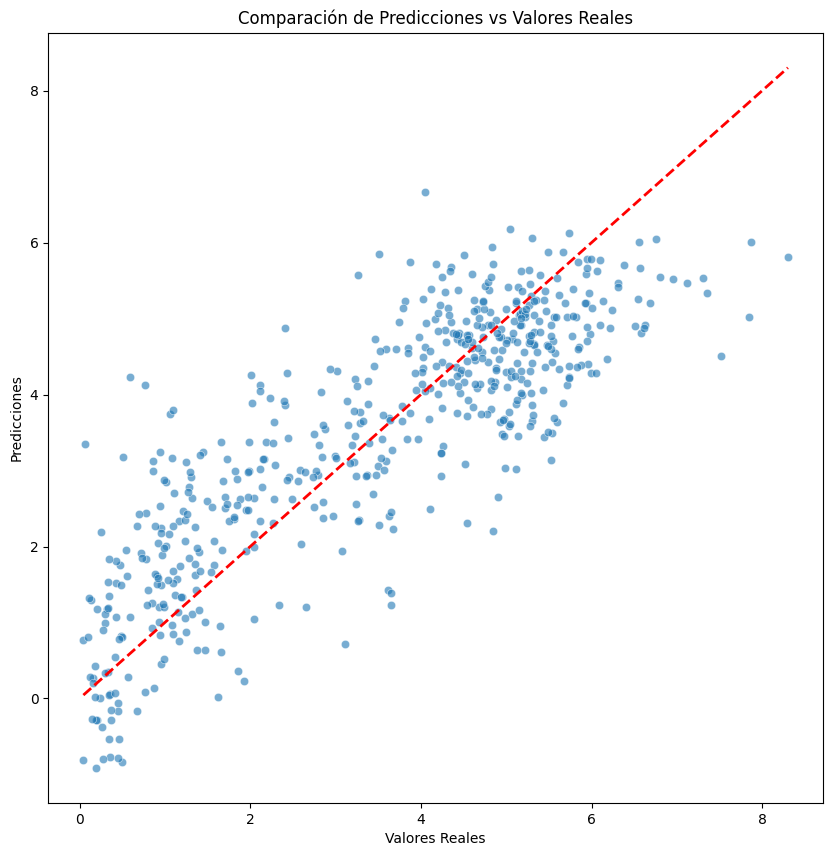

In [315]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

Para test

In [316]:
y_pred = lin_reg.predict(X_test_scaled)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', lin_reg.score(X_test_scaled, y_test))

MSE: 1.0502043662137448
RMSE: 1.0247947922456206
MAE: 0.8426189529962783
MAPE: 0.5515525773527803
R2: 0.7349967560827355


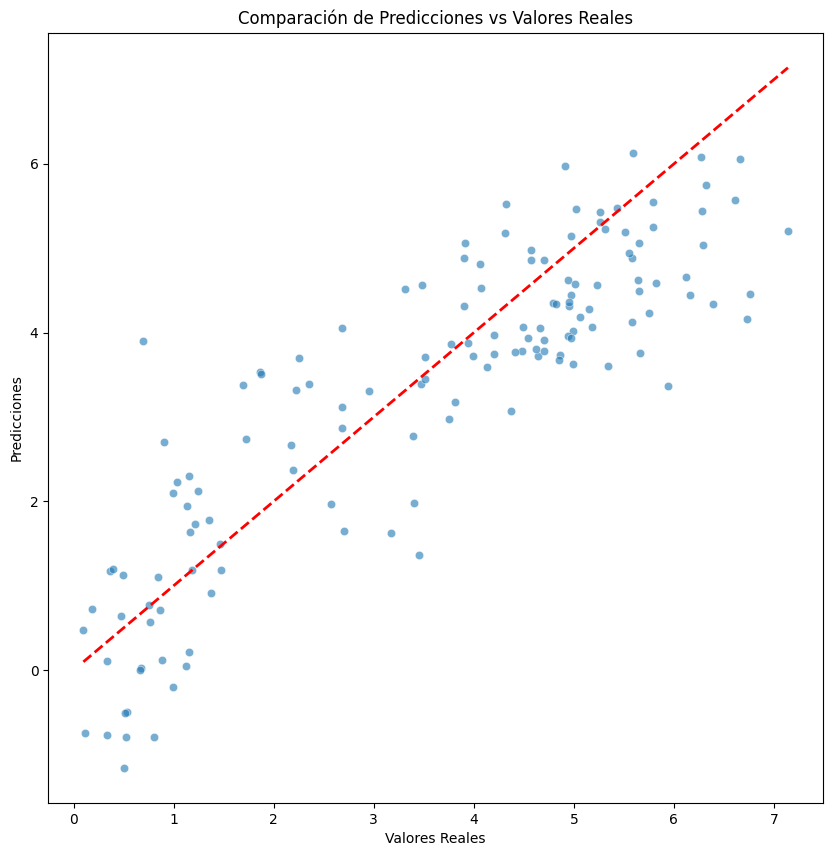

In [317]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

#### Elastic net

MSE: 1.0801735662698113
RMSE: 1.0393139882969975
MAE: 0.8416736621739377
MAPE: 0.557225477452689
R2: 0.7274344801220138


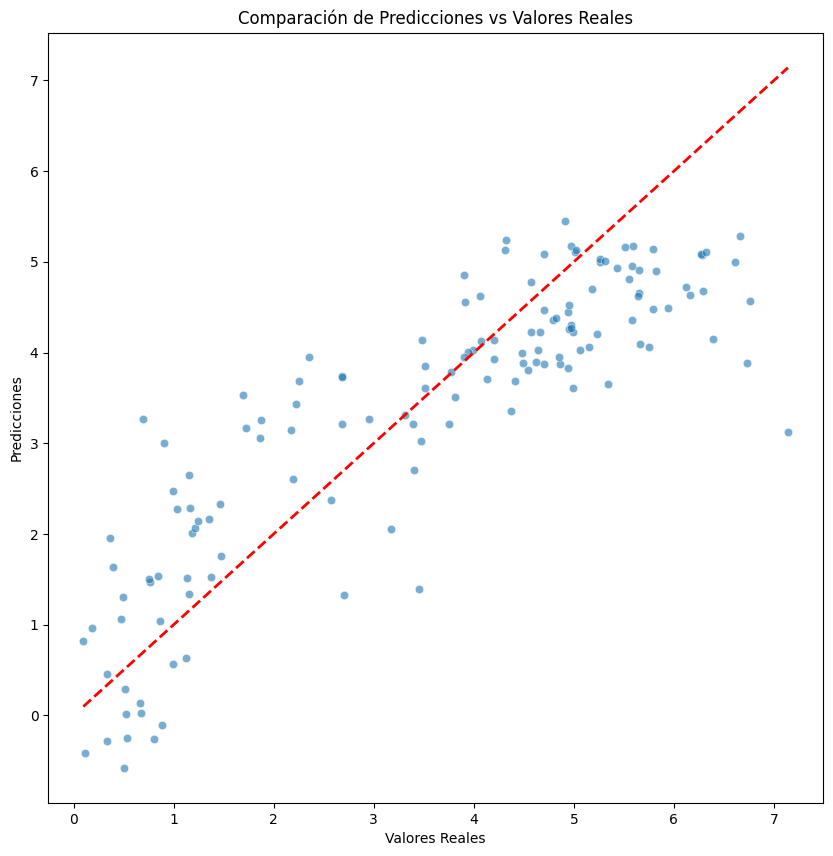

In [318]:
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(alpha= 0.2, l1_ratio= 0.1)
elastic_reg.fit(X_train_scaled,y_train)
y_pred = elastic_reg.predict(X_test_scaled)

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', elastic_reg.score(X_test_scaled, y_test))

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

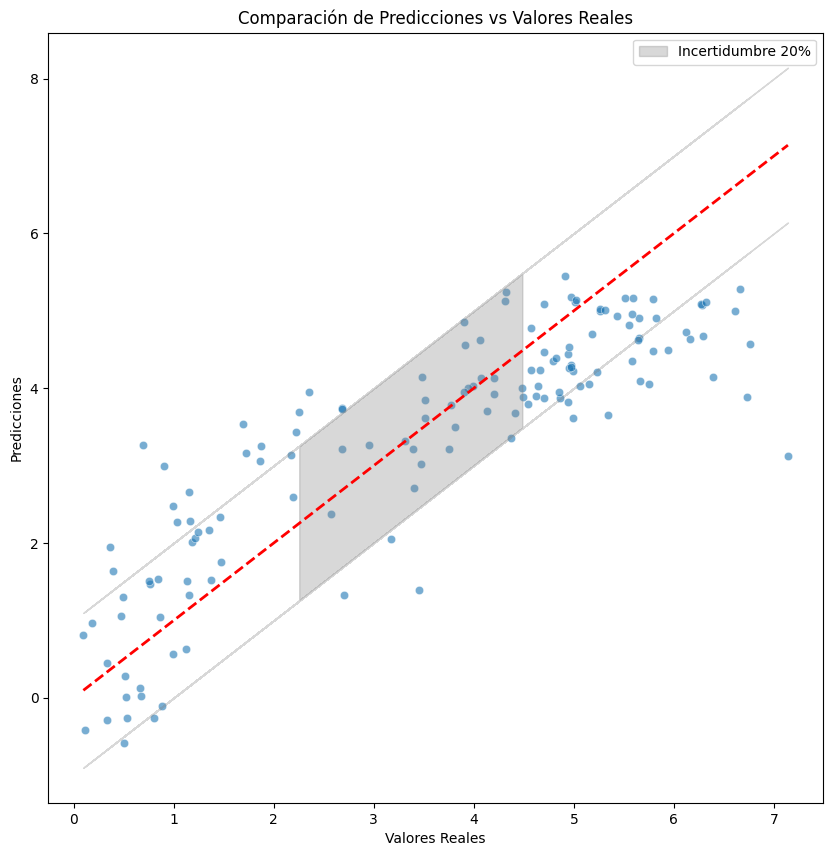

In [319]:
# Suponiendo que ya tienes y_test y y_pred definidos
plt.figure(figsize=(10, 10))

# Gráfico de dispersión
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Línea diagonal (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Calcular el 20% de incertidumbre
uncertainty = 1

# Área sombreada (más y menos 20% de incertidumbre)
plt.fill_between(y_test, y_test - uncertainty, y_test + uncertainty, color='gray', alpha=0.3, label='Incertidumbre 20%')

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')

# Leyenda
plt.legend()

# Mostrar gráfico
plt.show()


### Probar varios modelos. Comparación con Validación Cruzada (pre-optimización)

In [320]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

model_names = ["Regresion Lineal","Random Forest","XGBoost","LightGBM","CatBoost"]

lr = LinearRegression()
rf = RandomForestRegressor(random_state= 42)
xgb = XGBRegressor(random_state = 42)
lgb = LGBMRegressor(random_state= 42, verbose = -100)
cat  = CatBoostRegressor(random_state= 42, verbose = False)


model_set = [lr, rf, xgb, lgb, cat]

In [321]:
from sklearn.model_selection import cross_val_score

metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre == "Regresion Lineal":
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "neg_mean_absolute_percentage_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LinearRegression()
RandomForestRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
LGBMRegressor(random_state=42, verbose=-100)


KeyboardInterrupt: 

In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, MAPE: {(-np.mean(valores))}")
print(f"El ganador es {ganador}")

In [ ]:
'''for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")
print(f"El ganador es {ganador}")'''

### Optimizacion del modelo ganador


In [ ]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    "n_estimators": [50,100,200,400], # 100 es el valor por defecto 
    "max_depth": [5,10,15,None], # None es el valor por defecto
    "min_samples_leaf": [5,10,15], # 1 es el valor por defecto. Pero sobreajustaria mucho el modelo
    'min_samples_split': [2,5,10], # 2 es el valor por defecto    
    "max_features": ["sqrt","log2",None], # 1.0 (ó None) es el valor por defecto
    "max_samples": [0.3,0.6,1.0] # 1.0 (ó None) es el valor por defecto
}

rf_grid = GridSearchCV(rf,
                       param_grid= params_grid,
                       cv = 5,
                       scoring = "neg_root_mean_squared_error",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

In [ ]:
-rf_grid.best_score_

In [ ]:
rf_grid.best_params_

In [ ]:
y_pred = rf_grid.best_estimator_.predict(X_test)
y_pred = pd.Series(y_pred, index=X_test.index, name='Predictions')

argumentos = (y_test, y_pred)

print('MSE:', metrics.mean_squared_error(*argumentos))
print('RMSE:', np.sqrt(metrics.mean_squared_error(*argumentos)))
print('MAE:', metrics.mean_absolute_error(*argumentos))
print('MAPE:', metrics.mean_absolute_percentage_error(*argumentos))
print('R2:', rf_grid.best_estimator_.score(X_test, y_test))

In [ ]:
df_res = pd.DataFrame(y_test)

In [ ]:
df_res['pred'] = y_pred

In [ ]:
df_res['Class'] = test_set['IGBP_class']

In [ ]:
plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_res, x="LAI_Warren", y="pred", hue="Class")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()


In [ ]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Predicciones vs Valores Reales')
plt.show()

### Analisis de errores

Calculamos los residuos y vemos la distribución de esos errores.

In [ ]:
# Calcular residuos
residuos = y_pred - y_test

# Visualización de residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribución de Residuos')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.show()

Graficamos los residuos según el valor real para intentar ver patrones donde se concentran los errores.

In [ ]:
# Gráfica de dispersión de residuos
plt.scatter(y_test, residuos)
plt.title('Residuos vs. Valor Real')
plt.xlabel('Valor Real')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


In [ ]:
residuos

In [ ]:
test_set.columns

In [ ]:
test_set['LAIe_Warren'] = test_set['LAIe_Warren_up'].astype(float) + test_set['LAIe_Warren_down'].astype(float)

In [ ]:
test_set[abs(residuos) >= 2][['time','TIME_IS','delta','Site','IGBP_class','LAI_Warren','LAIe_Warren','LAI_Warren_down', 'LAI_Warren_err','LAIe_Warren_up','clumping_Warren_up','clumping_Warren_down','clumping_Warren_up_err','clumping_Warren_down_err']]

In [ ]:
sns.histplot(train_set['LAI_Warren_err'], kde=True, bins=50)

In [ ]:
sns.histplot(train_set['clumping_Warren_up_err'], kde=True, bins=50)

In [ ]:
sns.histplot(train_set['clumping_Warren_down_err'], kde=True, bins=50)

In [ ]:
test_set.IGBP_class.value_counts()

In [ ]:
train_set.IGBP_class.value_counts()

In [ ]:
df_cross['date_sat'] = pd.to_datetime(df_cross['date_sat'])

In [ ]:
test_set['IGBP_class'].value_counts()

In [ ]:

sns.histplot(test_set['IGBP_class'], kde=True)

In [ ]:
sns.histplot(df_cross['date_sat'].dt.year, kde=True)